In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

In [ ]:
dataset='./data/Vegetable Images'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

In [ ]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

In [ ]:
image_folder="Cucumber"  # The vegetable you want to display
number_of_images=2       # Number of images to display

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1
        
Preprocess()

In [ ]:
select_vegetable="Capsicum"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

In [ ]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

In [ ]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

In [ ]:
class_map = training_set.class_indices
class_map

In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

In [ ]:
model.save('model_inceptionV3_epoch5.h5')

In [ ]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

In [ ]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]: 
    layer_names.append(layer.name)
    
print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])

In [ ]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

In [ ]:
model.summary()

In [33]:
validation_data_dir = './data/Vegetable Images/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.
Test Accuracy: 0.992


In [34]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

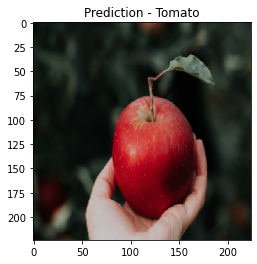

In [36]:
predict_image('apple1.jpg', model)

In [41]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [42]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

KeyError: 'Vegetable Images\\test\\Bean'

In [52]:

def predict_image(image, model):
    img_ = image.resize((224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    #plt.title("Prediction - {}".format(category[index]))
    #plt.imshow(img_array)

    return category[index]
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))
    

<class 'PIL.Image.Image'>
[[5.3960904e-03 1.9084806e-04 2.7200436e-02 1.9024171e-01 6.2987918e-04
  5.6394760e-04 3.2052931e-03 4.6272244e-04 5.5174343e-03 3.1621458e-03
  1.0045062e-04 1.3030966e-02 6.5230741e-03 3.5024690e-03 7.4027264e-01]]
14


In [56]:
predict_image(image, model)

AttributeError: 'JpegImageFile' object has no attribute 'img_to_array'

In [76]:

import base64
from PIL import Image
from io import BytesIO
from keras.preprocessing.image import img_to_array

def predict_image(base64_list, model):
    
    ingredients = []
    images_list = base64_list.split('-')
    
    for encoded_image in images_list:
        
        decoded_image_data = base64.b64decode(encoded_image)
        img = Image.open(BytesIO(decoded_image_data))
        img_ = img.resize((224, 224))
        img_array = img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.   
    
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        ingredients.append(category[index])

    return list(set(ingredients))



# Open the image file
with open('apple1.jpg', 'rb') as image_file:
    # Read the image data
    image_data = image_file.read()

# Encode the image data as a Base64 string
encoded_image = base64.b64encode(image_data).decode('utf-8')


test = predict_image(encoded_image, model)
print(test)



['Tomato']


In [71]:
with open('apple1.jpg', 'rb') as image_file:
    # Read the image data
    image_data = image_file.read()
    encoded_image = base64.b64encode(image_data).decode('utf-8')

encoded_image

'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAF6Ah8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD80Jpuo7063bpmoGTnmpoaDA0Y5Md6secNvWs5Wxxmn7j61BBYa459adFNnk8VneYS2PerMeeKAsaUL55FXYmzwazYW2irkMu1qCS15e7mq88YFS+dVe5kpBYoTgc1VarM3fmq+0EdeaZoRr97NO208Q9KUx496BMemMUmDya

In [73]:
list_of_images = base64.split('-')
decoded_image_data = base64.b64decode(encoded_image)